# Imposto de Renda

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
sns.set(style="white")

plt.rcParams['axes.titlesize'] = 20
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['axes.linewidth'] = 3
plt.rcParams['axes.labelpad'] = 15

plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['xtick.major.size'] = 8
plt.rcParams['xtick.major.width'] = 3

plt.rcParams['ytick.labelsize'] = 16
plt.rcParams['ytick.major.size'] = 8
plt.rcParams['ytick.major.width'] = 3

plt.rcParams['legend.fontsize'] = 14
plt.rcParams['legend.markerscale'] = 1

plt.rcParams['lines.markersize'] = 9
plt.rcParams['lines.linewidth'] = 2

### Lê os datasets

In [3]:
df_ativos = pd.read_csv('Dataset_ações_2019.csv')
df_ativos['Data'] = pd.to_datetime(df_ativos['Data'], format="%Y/%m/%d")
df_ativos.head()

,Data,Código,Mercado,Especificação,Tipo de Execução,Corretora,Quantidade de C/V,Valor Total,Preço de C/V,Preço Atual,L/P,Quantidade Atual
0,2019-07-11,CVCB3,Fracionário,CVC BRASIL ON NM,C,MODAL,10.0,530.00,53.00,53.00,0.0,10.0
1,2019-07-11,PETR4,Fracionário,PETROBRAS PN N2,C,MODAL,17.0,478.89,28.17,28.17,0.0,17.0
2,2019-07-11,RAIL3,Fracionário,RUMO S.A. ON NM,C,MODAL,20.0,443.40,22.17,22.17,0.0,20.0
3,2019-07-11,VALE3,Fracionário,VALE ON NM,C,MODAL,10.0,520.00,52.00,52.00,0.0,10.0
4,2019-07-19,CVCB3,Fracionário,CVC BRASIL ON NM,V,MODAL,-10.0,487.00,48.70,53.00,-43.0,0.0


In [30]:
df_proventos = pd.read_excel('Proventos - 2019.xlsx')
df_proventos.head()

,Ativo,Especificação,Código,Tipo,Previsão,Valor,Corretora,Recebi
0,PETROBRAS,PN N2,PETR4,jcp,2019-10-01,3.40,modal,s
1,MAGAZ LUIZA,ON NM,MGLU3,jcp,NaT,2.06,modal,n
2,MAGAZ LUIZA,ON NM,MGLU3,jcp,NaT,1.01,modal,n
3,PETROBRAS,PN N2,PETR4,jcp,2020-02-01,6.63,modal,s
4,PETROBRAS,PN N2,PETR4,jcp,2020-02-01,13.93,modal,s


# Vendas acima de 20k

- Meses com venda acima de 20k tem que pagar IR no próximo mês de 15% para swing trade.

In [5]:
df_ativos['Mês'] = df_ativos['Data'].dt.strftime('%B')

In [6]:
df_vendas = df_ativos.groupby(['Mês', 'Tipo de Execução'], sort=False).sum().reset_index()

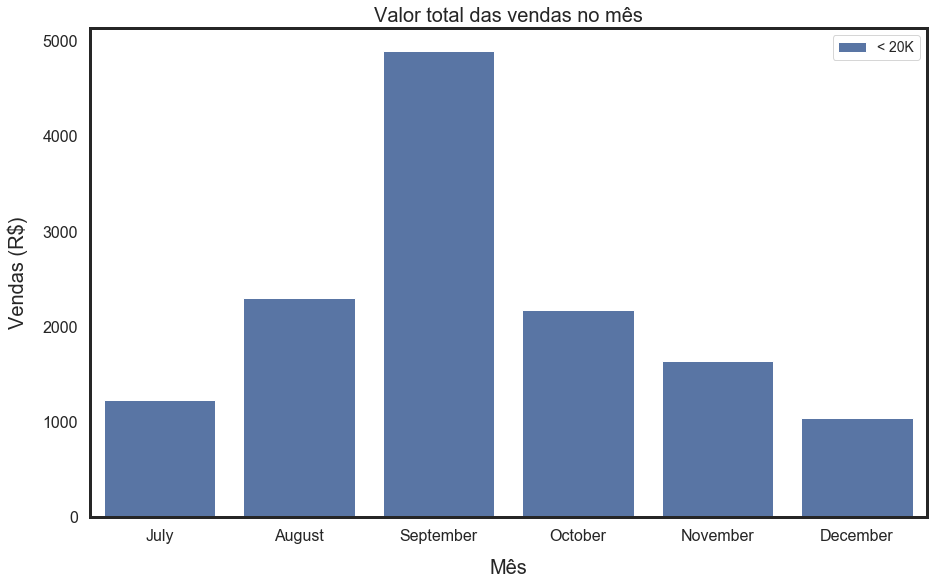

In [7]:
plt.figure(figsize=[15, 9])

palette_c = ['b' if val < 20000 else 'r' for val in df_vendas['Valor Total']]
more_20k = [ '< 20K' if val < 20000 else '> 20' for val in df_vendas['Valor Total'] ]

sns.barplot(data = df_vendas, x = 'Mês', hue=more_20k, y = 'Valor Total', palette=palette_c, ci=None)

plt.ylabel('Vendas (R$)')
plt.title('Valor total das vendas no mês')

plt.show()

# Declaração mensal

- Declarar prejuízos para abatimentos em cobranças posteriores.

In [8]:
lucro_mes = df_ativos.loc[(df_ativos['L/P'] != 0.0), ['Data', 'L/P']]
lucro_mes['Mês'] = lucro_mes['Data'].dt.strftime('%b')
lucro_mes = lucro_mes.groupby(['Mês'], sort=False).sum().reset_index()

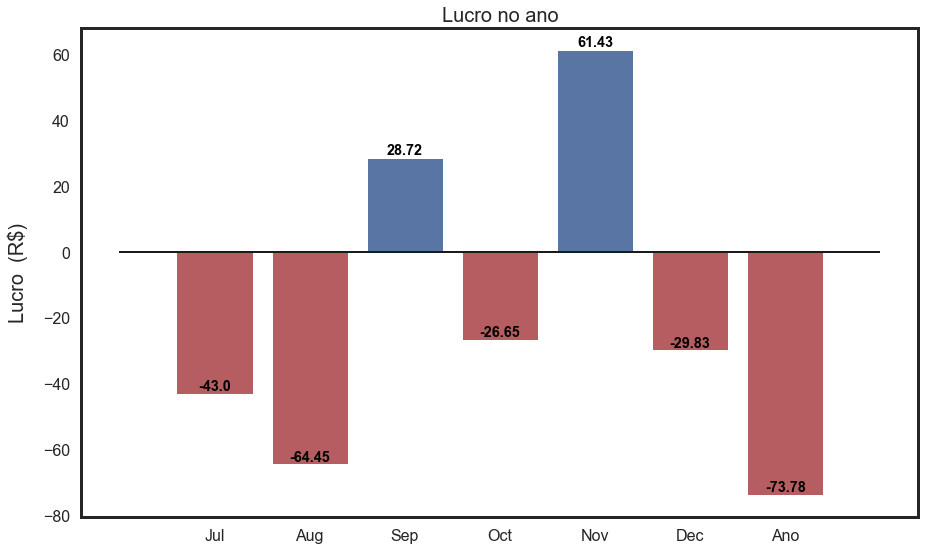

In [9]:
plt.figure(figsize=[15, 9])

tot = pd.DataFrame(data={'Mês': ['Ano'], 'L/P': [lucro_mes['L/P'].sum().round(2)]})
    
df = lucro_mes.append(tot, ignore_index=True)

palette_c = ['r' if c < 0.0 else 'b' for c in df['L/P']]

g = sns.barplot(data = df, x = 'Mês', y = 'L/P', palette=palette_c)

for index, row in df[['L/P']].reset_index().values:
    g.text(index, row, np.round(row, 2), color='black', ha="center", va='bottom',
           fontsize='large', fontweight='bold')
    
plt.hlines(y=0, xmax=df.shape[0], xmin=-1)
plt.ylabel('Lucro  (R$)')
plt.xlabel('')
plt.title('Lucro no ano')
plt.show()

# Proventos

In [60]:
def f(tipo, previsão):
    df = df_proventos[df_proventos['Tipo'] == tipo]

    mask_year = df['Previsão'].dt.strftime('%Y')  == previsão
    mask_not_year = df['Previsão'].dt.strftime('%Y')  != previsão

    print('\nJá creditados em {0}:'.format(previsão))

    display(df[mask_year])

    print('\nCrédito em transito:')
    display(df[mask_not_year])

interactive(f, tipo=['jcp', 'div'] , previsão=['2019'])

interactive(children=(Dropdown(description='tipo', options=('jcp', 'div'), value='jcp'), Dropdown(description=…

# Funções

In [10]:
def carteira_de_acoes_atual(df, offline = False):
    
    carteira = pd.DataFrame(columns=df.columns)

    cods = df['Código'].unique()
    
    for cod in cods:
        
        last_idx = df[df[['Código']] == cod].last_valid_index() 
        
        carteira = carteira.append(df.loc[last_idx], ignore_index=True)

    carteira = carteira[carteira['Quantidade Atual'] != 0.0]
    
    carteira.sort_values(by='Data', ascending=True, inplace=True)
    
    drop_columns = ['Especificação', 'Tipo de Execução', 'Quantidade de C/V', 'Mercado', 'Preço de C/V']
    
    carteira.drop(drop_columns, inplace=True, axis=1)
    
    carteira.rename(columns={'Preço Atual': '<Preço>'}, inplace=True)
    
    carteira.reset_index(drop=True, inplace=True)
    
    carteira['<Valor Total>'] = carteira['Quantidade Atual'] * carteira['<Preço>']
    
    if offline == False:
    
        carteira['Preço Atual'] = get_market_values(carteira['Código'])

        carteira['Valor Total Atual'] = carteira['Quantidade Atual'] * carteira['Preço Atual']

        carteira['L/P'] = carteira['Quantidade Atual'] * ( carteira['Preço Atual'] - carteira['<Preço>'] )

        carteira['L/P (%)'] = (carteira['L/P'] / (carteira['<Preço>'] * carteira['Quantidade Atual'])) * 100.0

        carteira['L/P'] = carteira['L/P'].round(2)

        carteira['L/P (%)'] = carteira['L/P (%)'].round(2) 

        carteira['<Preço>'] = carteira['<Preço>'].round(2)


        cols_ordenadas = ['Data', 'Código', 'Quantidade Atual', '<Preço>', '<Valor Total>',
                          'Preço Atual', 'Valor Total Atual', 'L/P', 'L/P (%)', 'Corretora']

    elif offline == True:
        
        cols_ordenadas = ['Data', 'Código', 'Quantidade Atual', '<Preço>', '<Valor Total>', 'Corretora']
        
    return carteira[cols_ordenadas]

# Posições

In [11]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

### Zerada

In [12]:
def f(corretora):

    df = df_ativos[df_ativos['Corretora'] == corretora]

    cods = df['Código'].unique()

    index = []

    for cod in cods:

        qnt = df.loc[df['Código'] == cod, 'Quantidade Atual'].tail(1)

        idx = qnt.index.values[0]

        if qnt.values[0] == 0.0:

            index.append(idx)

    df = df_ativos.iloc[index, :].copy()

    df.rename(columns={'Preço Atual': '<Preço>'}, inplace=True)
    
    df['<Valor Total>'] =  - df['Quantidade de C/V'] * df['<Preço>']
    
    df = df.sort_values('Data')
    
    df['Posição'] = 'Zerada'
    
    display(df[['Data', 'Código', 'Quantidade de C/V', '<Preço>', '<Valor Total>', 'Corretora', 'Posição']])

interactive(f, corretora=df_ativos['Corretora'].unique())

interactive(children=(Dropdown(description='corretora', options=('MODAL', 'CLEAR'), value='MODAL'), Output()),…

### Comprada

In [13]:
def f(corretora):
    
    df = df_ativos[df_ativos['Corretora'] == corretora]
    df = carteira_de_acoes_atual(df.copy(), offline=True)
    df['Posição'] = 'Comprada'
    display(df)
    
interactive(f, corretora=df_ativos['Corretora'].unique())

interactive(children=(Dropdown(description='corretora', options=('MODAL', 'CLEAR'), value='MODAL'), Output()),…

# Movimentações por ativo

In [14]:
def f(ativo):
    
    display(df_ativos[df_ativos['Código'] == ativo].drop('Mês', axis=1))
    
interactive(f, ativo=df_ativos['Código'].unique())

interactive(children=(Dropdown(description='ativo', options=('CVCB3', 'PETR4', 'RAIL3', 'VALE3', 'ANIM3', 'B3S…

# Movimentação por corretora

In [17]:
def f(corretora):
    
    display(df_ativos[df_ativos['Corretora'] == corretora].drop('Mês', axis=1))
    
interactive(f, corretora=df_ativos['Corretora'].unique())